# Train and deploy a model for the Amazon Bin Image counting problem

This notebook contains code to perform hyperparameter tuning, training, debugging of a multi-class image classifier for for counting objects in images from bins in Amazon distribution centers. During the EDA phase the problem has been reduced to a 


The model is implemented using PyTorch. The training data comes directly from the public dataset at https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds. The original dataset contains >500,000 images, but in this project a randomly selected subsample of 50,000 images is used. See EDA for details. 

## Install debugging tools

Run only once.

In [2]:
!pip install smdebug 

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


## Create S3 bucket for the models

Run only once.

In [3]:
import boto3 

In [4]:
client = boto3.client('s3')
response = client.create_bucket(
    ACL='private',
    Bucket='amazon-bin-images-models',
)

## Import useful modules

In [1]:
import os
import sys
import io
import base64
import json
import IPython
import numpy as np
import pandas as pd
from PIL import Image
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from sagemaker.pytorch import PyTorchModel,PyTorchPredictor
from sagemaker.predictor import Predictor

[2022-01-22 23:31:34.463 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:1352 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Hyperparameter Tuning

The code below sets up a series of hyperparameter sweeps to find the set that achieves the best model performance. The latter is quantified by a series of metrics computed from each dataset: 
- Average training loss.
- Training accuracy.
- Training RMSE.
- Average validation loss.
- Validation accuracy.
- Validation RMSE.
- Average testing loss.
- Testing accuracy.
- Testing RMSE.

**The average validation loss is the metric to minimize to perform hyperparameter tuning.**

In [9]:
# Hyperparameter ranges
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.01),
    "batch_size": CategoricalParameter([32, 64]),
    "epochs": IntegerParameter(5, 50)
}

# Objective metric 
objective_metric_name = "Validation Loss"
objective_type = "Minimize"
metric_definitions = [
    {"Name": "Training Loss", "Regex": "Training Loss: ([0-9\\.]+)"},
    {"Name": "Training Accuracy", "Regex": "Training Accuracy: ([0-9\\.]+)"},
    {"Name": "Training RMSE", "Regex": "Training RMSE: ([0-9\\.]+)"},
    {"Name": "Validation Loss", "Regex": "Validation Loss: ([0-9\\.]+)"},
    {"Name": "Validation Accuracy", "Regex": "Validation Accuracy: ([0-9\\.]+)"},
    {"Name": "Validation RMSE", "Regex": "Validation RMSE: ([0-9\\.]+)"},
    {"Name": "Testing Loss", "Regex": "Testing Loss: ([0-9\\.]+)"},
    {"Name": "Testing Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"},
    {"Name": "Testing RMSE", "Regex": "Testing RMSE: ([0-9\\.]+)"},
]

In [10]:
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    base_job_name='amazon-bin-images-pytorch',
    instance_count=1,
    instance_type='ml.g4dn.xlarge', 
    source_dir='./',
    entry_point='hyperparameter_opt.py',
    output_path='s3://amazon-bin-images-models',
    framework_version='1.8',
    py_version='py36',
)
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [11]:
os.environ['SM_CHANNEL_TRAINING']='s3://amazon-bin-images-sub'
os.environ['SM_MODEL_DIR']='s3://amazon-bin-images-models'
os.environ['SM_OUTPUT_DATA_DIR']='s3://amazon-bin-images-models'
tuner.fit({'training': 's3://amazon-bin-images-sub'},wait=False)

## Describe tuning results

In [4]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220120-1457'
)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,"""64""",10.0,0.007841,pytorch-training-220120-1457-002-658db242,Completed,1.403171,2022-01-20 15:00:35+00:00,2022-01-20 16:27:59+00:00,5244.0
3,"""64""",14.0,0.004837,pytorch-training-220120-1457-003-1885b54f,Completed,1.370983,2022-01-20 15:00:33+00:00,2022-01-20 17:02:11+00:00,7298.0
5,"""32""",24.0,0.003756,pytorch-training-220120-1457-001-75ad7c29,Completed,1.336339,2022-01-20 15:00:35+00:00,2022-01-20 18:14:27+00:00,11632.0
2,"""64""",26.0,0.002727,pytorch-training-220120-1457-004-445c96ca,Completed,1.333464,2022-01-20 15:00:42+00:00,2022-01-20 18:22:07+00:00,12085.0
0,"""32""",15.0,0.001229,pytorch-training-220120-1457-006-9f61a280,Completed,1.332356,2022-01-20 17:06:38+00:00,2022-01-20 19:12:40+00:00,7562.0
1,"""32""",50.0,0.007948,pytorch-training-220120-1457-005-2fa0cd2a,Completed,1.309559,2022-01-20 16:31:25+00:00,2022-01-20 22:46:18+00:00,22493.0


In [5]:
jobs.to_csv('hyperparameter_tuning_results.csv',index=False)

## Select best model hyperparameters

In [2]:
# From tuner object
#best_estimator=tuner.best_estimator()

# If kernel dies - retrieve from completed training job
# From log file
jobs = pd.read_csv('hyperparameter_tuning_results.csv')
ibest = np.argmin(jobs.FinalObjectiveValue)
best_training_job_name = jobs.loc[ibest,'TrainingJobName']
best_estimator = sagemaker.estimator.Estimator.attach(best_training_job_name)


2022-01-20 22:46:18 Starting - Preparing the instances for training
2022-01-20 22:46:18 Downloading - Downloading input data
2022-01-20 22:46:18 Training - Training image download completed. Training in progress.
2022-01-20 22:46:18 Uploading - Uploading generated training model
2022-01-20 22:46:18 Completed - Training job completed


In [3]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Validation Loss',
 'batch_size': '"32"',
 'epochs': '50',
 'learning_rate': '0.007948304077030333',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"amazon-bin-images-pytorch-2022-01-20-14-57-57-476"',
 'sagemaker_program': '"hyperparameter_opt.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://amazon-bin-images-models/amazon-bin-images-pytorch-2022-01-20-14-57-57-476/source/sourcedir.tar.gz"'}

In [4]:
hyperparameters = {
    "batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), 
    "learning_rate": best_estimator.hyperparameters()['learning_rate'], 
    "epochs": best_estimator.hyperparameters()['epochs']
}

In [5]:
hyperparameters

{'batch_size': 32, 'learning_rate': '0.007948304077030333', 'epochs': '50'}

## Profiler and Debugger settings

In [6]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [7]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

## Train model with best hyperparameters, debugger and profiler

In [22]:
mi_estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    base_job_name='amazon-bin-images-pytorch',
    instance_count=2,
    instance_type='ml.g4dn.xlarge', 
    source_dir='./',
    entry_point='train.py',
    output_path='s3://amazon-bin-images-models',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

In [23]:
os.environ['SM_CHANNEL_TRAINING']='s3://amazon-bin-images-sub'
os.environ['SM_MODEL_DIR']='s3://amazon-bin-images-models'
os.environ['SM_OUTPUT_DATA_DIR']='s3://amazon-bin-images-models'
mi_estimator.fit({"training": "s3://amazon-bin-images-sub"},wait=False)

## Locate model artifacts

In [27]:
model_location=mi_estimator.model_data

In [28]:
model_location

's3://amazon-bin-images-models/amazon-bin-images-pytorch-2022-01-21-01-20-39-812/output/model.tar.gz'

## Prepare Deployment

In [ ]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [2]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [3]:
model_location = 's3://amazon-bin-images-models/amazon-bin-images-pytorch-2022-01-21-01-20-39-812/output/model.tar.gz'

mi_pytorch_model = PyTorchModel(
    model_data=model_location, 
    role=sagemaker.get_execution_role(),
    entry_point='inference.py',
    py_version='py36',
    framework_version='1.8',
    predictor_cls=ImagePredictor
)

In [4]:
predictor = mi_pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [5]:
endpoint_name = predictor.endpoint_name
endpoint_name

'pytorch-inference-2022-01-22-23-17-13-998'

## Test deployed model 1 - Send image directly to endpoint

In [2]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [3]:
endpoint_name = 'pytorch-inference-2022-01-22-23-17-13-998'
predictor = PyTorchPredictor(
    endpoint_name,
    serializer=jpeg_serializer,
    deserializer=json_deserializer
)

In [4]:
def get_image(
    idd,
    s3bucket,
    s3prefix
):
    '''
    Retrieve an image for a given id
    
    Input : 
        idd : int, id of the image
        
        s3bucket : str, name of the bucket
        
        s3prefix : str, prefix
        
    Output : 
        img : ImageFile, image object
    '''
    client = boto3.client('s3')
    key = os.path.join(s3prefix,'%05d.jpg'%idd)
    response = client.get_object(Bucket=s3bucket,\
                                 Key=key)
    img = response['Body'].read()
    
    return(img)

In [5]:
img_id = 2
s3bucket = 'amazon-bin-images-sub'
s3prefix = ''
img_bytes = get_image(img_id,s3bucket,s3prefix)
type(img_bytes)

bytes

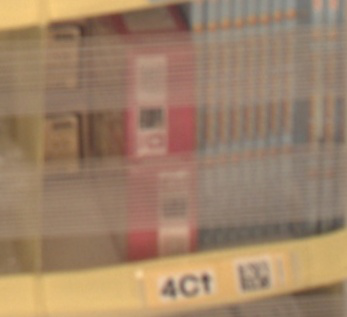

In [6]:
Image.open(io.BytesIO(img_bytes))

In [7]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [8]:
np.argmax(response, 1)

array([3])

## Test deployed model 2 - Send image in a JSON request

In [9]:
encoded_img = base64.b64encode(img_bytes).decode('ASCII')
json_request = json.dumps({'image' : encoded_img})

decoded_img = base64.b64decode(json.loads(json_request)['image'].encode('ASCII'))
decoded_img == img_bytes

True

In [10]:
response=predictor.predict(json_request, initial_args={"ContentType": "application/json"})

In [11]:
np.argmax(response, 1)

array([3])

## Test Lambda function invocation

NOTE: before this step deploy Lambda function with full S3 access, and give SageMaker access to Lambda.

In [12]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [13]:
endpoint_name = 'pytorch-inference-2022-01-22-23-17-13-998'
predictor = PyTorchPredictor(
    endpoint_name,
    serializer=jpeg_serializer,
    deserializer=json_deserializer
)

In [14]:
lambda_client = boto3.client('lambda')
request = json.dumps({
    "s3_bucket" : "amazon-bin-images-sub",
    "s3_prefix" : "",
    "endpoint_name" : endpoint_name,
    "image_name" : "00002.jpg"
})
response = lambda_client.invoke(
    FunctionName='serve-cv-object-counter',
    InvocationType = "RequestResponse",
    Payload=request
)
output = json.loads(response['Payload'].read())['body']

In [15]:
decoded_img = base64.b64decode(output['image'].encode('ASCII'))
prediction = output['prediction']
decoded_img == img_bytes

True

In [16]:
np.argmax(prediction,1)

array([3])